In [1]:
# this lets us use the figures interactively
%matplotlib inline

import os
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.ion() # make the plotting interactive

In [2]:
# generate matplotlib handles to create a legend of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

In [3]:
def scale_bar(ax, location=(0.92, 0.95)):
    x0, x1, y0, y1 = ax.get_extent()
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    ax.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=ax.projection)
    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    ax.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=ax.projection)

    ax.text(sbx, sby-4500, '20 km', transform=ax.projection, fontsize=8)
    ax.text(sbx-12500, sby-4500, '10 km', transform=ax.projection, fontsize=8)
    ax.text(sbx-24500, sby-4500, '0 km', transform=ax.projection, fontsize=8)


In [4]:
#import data file: flood, buildings, roads, population excel file, county outline, sa outline
flood= gpd.read_file(os.path.abspath('Project_datafiles/Flood_2m.shp'))
roads= gpd.read_file(os.path.abspath('Project_datafiles/Fermanagh_roads.shp'))
buildings= gpd.read_file(os.path.abspath('Project_datafiles/Building_Fermanagh.shp'))
pop_demography=gpd.read_file(os.path.abspath('Project_datafiles/pop_demography.csv'))
outline = gpd.read_file(os.path.abspath('Project_datafiles/Fermanagh_DCA.shp'))
small_area= gpd.read_file(os.path.abspath('Project_datafiles/SA_poly.shp'))
land_cover= gpd.read_file(os.path.abspath('Project_datafiles/LCM_Fermanagh.shp'))

In [5]:
outline.head()

,AREA,PERIMETER,LGD_,LGD_ID,LGDNAME,DATASET,OSNI_SCALE,geometry
0,1.876782e+09,314692.19,120,18813,FERMANAGH,LGDs 1993,1:50000,"POLYGON ((219214.053 373380.472, 219408.879 37..."


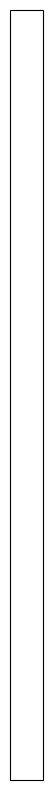

In [6]:
myFig = plt.figure(figsize=(10, 10))  # create a figure of size 10x10 (representing the page size in inches)

myCRS = ccrs.UTM(29)  # create a Universal Transverse Mercator reference system to transform our data.
# be sure to fill in XX above with the correct number for the UTM Zone that Northern Ireland is part of.

ax = plt.axes(projection=myCRS)  # finally, create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.

In [7]:
# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = outline.total_bounds
ax.add_feature(outline_feature) # add the features we've created to the map.

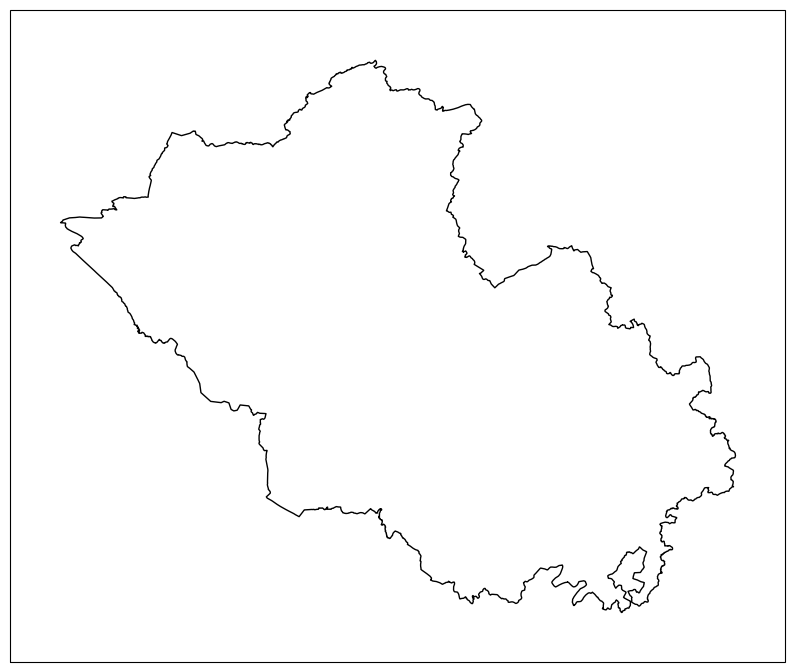

In [8]:
# using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=myCRS) # because total_bounds 
# gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

myFig ## re-draw the figure

In [9]:
#create % column for elderly and child ?

In [10]:
#join sa shape file with excel pop file

In [11]:
#create column pop density

In [12]:
#all data shapefile clipped to flood polygon with within

In [13]:
#analyses:-tot pop in flood polygon
#         - nbr resident houses
#         - tot length of road impacted and class A roas
#         - Sa with highest pop density and if any are adjacent
#         - SA with less than avg pop density
#         - which landcover types has highest area in flood poly
#         - total area flooded per landcover types
#         - SA with highest % of elderly/child
#         - SA with low pop density but high child %
#         - SA with medical building
#         - residential building furtherest from medical build (use original dataset ?)
#         - SA centre furthest from medical building

In [14]:
#add scale and legend handle

In [15]:
#create map and add features to map
# do second map with landcover

In [16]:
#different labels depending on building class and road class

In [17]:
#grid lines